In [ ]:
!pip install datasets

In [ ]:
import os
os.environ["WANDB_MODE"] = "disable"
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
#Import libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Load datasets
train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df = train_df.rename(columns={'target': 'label'})

In [ ]:
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Display basic information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   label     7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train_df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
label,0


In [ ]:
test_df.isnull().sum()

,0
id,0
keyword,26
location,1105
text,0


In [ ]:
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
keywords = train_df['keyword'].unique()
keywords

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()

    return text

In [ ]:
# Apply the cleaning function to both DataFrames
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
test_ids = test_df['id']

# Drop unnecessary columns
train_df.drop(columns=['id', 'location', 'keyword'], inplace=True)
test_df.drop(columns=['id', 'location', 'keyword'], inplace=True)

In [ ]:
# Features and labels
X = train_df['text']
y = train_df['label']

# Oversampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X.values.reshape(-1, 1), y)

# Convert resampled data back to DataFrame
train_df = pd.DataFrame({'text': X.flatten(), 'label': y})

In [ ]:
train_df.sample(15)

,text,label
8369,see aug poconorecord how many households have ...,1
7279,whirlwind head scissor on ktfounder remymarcel...,0
4663,tech data overload the growing demand for cont...,0
6199,smoke the weed snoop lion ft collie buddz,0
1104,i went to school in a bombed out east end of l...,1
2367,hereûªs what caused a metro train to derail i...,1
8477,school bus hijacker given parole after years,1
7542,wreckage conclusively confirmed as from missin...,1
3114,southkorea dogs preparedelectrocutedboiling wa...,0
4643,thanks i know you all get inundated have a goo...,0


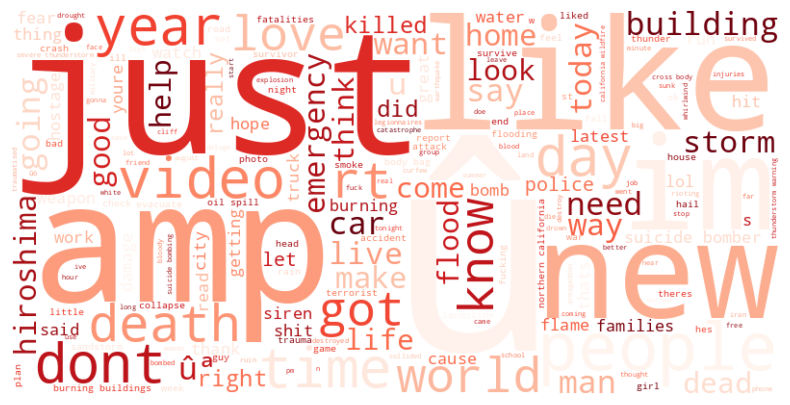

In [ ]:
text_data = " ".join(train_df['text'])

# Generate word cloud with a red color scheme
wordcloud = WordCloud(
    stopwords=ENGLISH_STOP_WORDS,
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    colormap='Reds'  # Use 'Reds' colormap for shades of red
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

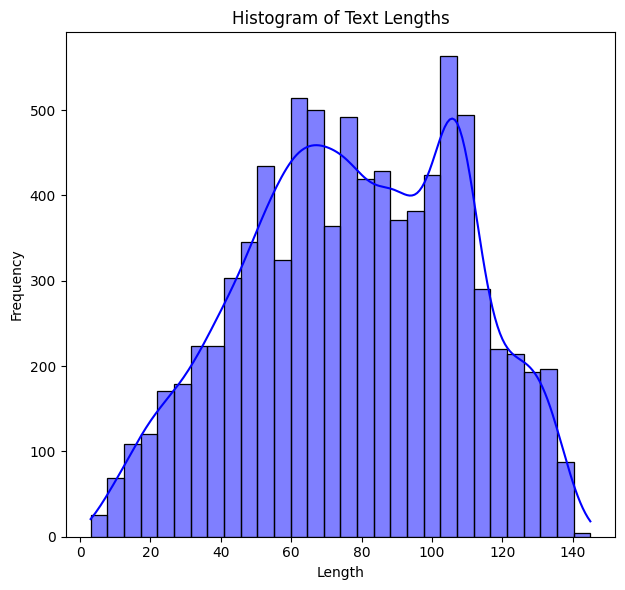

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['text'].apply(len), bins=30, kde=True, color='blue')
plt.title('Histogram of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

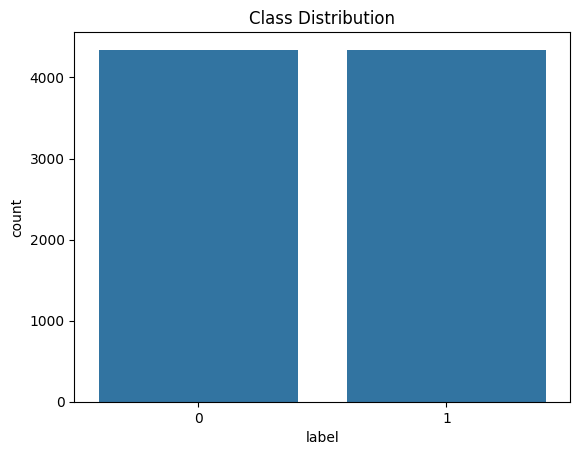

In [ ]:
# Visualize class distribution
sns.countplot(data=train_df, x='label')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Convert the pandas DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Split the dataset into training and validation sets
train_test_split = train_dataset.train_test_split(test_size=0.2, seed=42)

# Extract the train and validation datasets
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

In [ ]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 6947
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1737
 }),
 Dataset({
     features: ['text'],
     num_rows: 3263
 }))

In [ ]:
seed=42
random.seed(seed)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issue

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6947 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1737 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6947
})

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    lr_scheduler_type='cosine',
    fp16=True,
    report_to=None
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)  # Get the predicted class labels
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    accuracy = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Define the learning rate scheduler
total_steps = len(tokenized_train_dataset) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.06,
    num_training_steps=total_steps
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    optimizers=(optimizer, scheduler),
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.387500,0.381850,0.845135,0.873108,0.824176,0.847937
2,0.345600,0.388631,0.836500,0.837284,0.853846,0.845484
3,0.295100,0.377746,0.850317,0.848712,0.869231,0.858849


TrainOutput(global_step=654, training_loss=0.3942089133670935, metrics={'train_runtime': 121.3563, 'train_samples_per_second': 171.734, 'train_steps_per_second': 5.389, 'total_flos': 335479442803500.0, 'train_loss': 0.3942089133670935, 'epoch': 3.0})

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

In [ ]:
print("Evaluation Results:")
print(f"Loss: {eval_results['eval_loss']:.4f}")
print(f"Accuracy: {eval_results['eval_accuracy']:.2%}")
print(f"Precision: {eval_results['eval_precision']:.2%}")
print(f"Recall: {eval_results['eval_recall']:.2%}")
print(f"F1 Score: {eval_results['eval_f1']:.2%}")
print(f"Epoch: {eval_results['epoch']}")

Evaluation Results:
Loss: 0.3777
Accuracy: 85.03%
Precision: 84.87%
Recall: 86.92%
F1 Score: 85.88%
Epoch: 3.0


In [ ]:
# Predict on the test dataset
predictions = trainer.predict(tokenized_test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [ ]:
# Create a DataFrame with the predictions
results = pd.DataFrame({
    'id': test_ids,
    'target': predicted_labels
})

In [ ]:
results.to_csv('submission.csv', index=False)